# Behavioral cloning

Behavioral cloning is a basic approach to teaching artificial agents how to behave in an environment. The approach consists in teaching the agent to mimic the behavior of an agent in similar situations.

In [161]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from dataclasses import dataclass
import cv2
from IPython.display import Video
import json
import pandas as pd
import seaborn as sns
from copy import deepcopy

In [162]:
# set seeds
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

We're going to use OpenAI's gym and in particular their "Ant-v4" environment, which is a 3D world with normal physics where a four-legged ant needs to learn to walk/run on an infinite plane.

In [163]:
env_name = 'Ant-v4'
env = gym.make(env_name, use_contact_forces=True, render_mode='rgb_array', terminate_when_unhealthy=False)
act_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]
print(f'The {env_name} environment has a {act_dim}-dimensional action space and a {obs_dim}-dimensional observation space.')

The Ant-v4 environment has a 8-dimensional action space and a 111-dimensional observation space.


As per the [OpenAI gym documentation](https://www.gymlibrary.dev/), an observation in the Ant-v4 environment consists of "positional values of different body parts of the ant, followed by the velocities of those individual parts (their derivatives) with all the positions ordered before all the velocities" (this sums up to 111 different numbers, meaning an observation is a 111-dimensional object). An action, in turn, represents "the torques applied at the hinge joints" (there are 8 such joints so an action is a 8-dimensional object). Both the action space and the observation space, therefore, are continuous (real-valued). The goal of this environment is for the ant to learn how to walk/run toward the right. 

Check the [Ant-v4 documentation](https://www.gymlibrary.dev/environments/mujoco/ant/) for more details about the observation space, action space, and the way rewards are calculated.

In [164]:
def pprint(d): print(json.dumps(d, indent=4))

In [165]:
env.reset() # needed before we can "step" a policy through an environment
ac = env.action_space.sample()
print('action: ', ac)
ob, rew, done, truncated, info = env.step(ac)
print('observation:', ob)
pprint(info)

action:  [ 0.55255     0.31260723 -0.6202682  -0.7472796   0.84378225 -0.3842947
  0.81080663 -0.40647927]
observation: [ 6.94464432e-01  9.99237701e-01 -3.21023765e-02 -2.02855106e-02
 -9.05272311e-03 -2.57070179e-02  3.61886737e-01  1.69830759e-01
 -4.55235848e-01  2.11830114e-01 -4.58859544e-01  4.50416827e-02
  4.53627050e-01 -3.16915123e-01  4.03604237e-01  2.67254867e-01
 -6.94800670e-02  5.08523722e-01 -1.66107009e+00 -4.27602856e+00
  8.04860752e+00  6.07402039e+00 -1.08041623e+01  5.84466592e+00
 -1.10181402e+01  3.97595076e+00  1.01739680e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0

The reward at each step is a function of whether the ant is going in the right direction and has good control. See [the documentation](https://www.gymlibrary.dev/environments/mujoco/ant/#rewards) for more details. The variable `done` is a boolean for whether the ant has reached 1000 steps (the maximum number of steps in the environment). The variable `truncated` is also a boolean indicating whether the ant is unhealthy.

## Dummy ant

Our goal is to teach an agent (in this case, an ant) a "policy" for how to behave. A policy is a mapping from observation to action. To start, let's create a dummy policy where we randomly sample an action at each step:

In [166]:
class DummyModel(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
    
    def forward(self, obs):
        # obs is a tensor of shape (batch_size, obs_dim)
        ac = torch.from_numpy(np.array([self.env.action_space.sample() for _ in obs]))
        # We sample a random action for each observation
        # in our batch.
        # `ac` has shape (batch_size, act_dim)
        return ac

When a policy is run, it creates a *rollout* (*episode* and *path* are two other common alternative terms for the same thing). A rollout is a sequence of observations, actions, and rewards. For each time step in a rollout, we also keep track of a boolean for whether the rollout has ended. Finally, we can also keep track of the visual information of the observations in the form of images. When running a policy in an environment, it's useful to create a `Rollout` class that will hold all that information for us. We also add a computed property to calculate the total reward accrued during an episode, which will prove useful later on.

In [167]:
@dataclass
class Rollout:
    observation: np.ndarray
    action: np.ndarray
    next_observation: np.ndarray
    reward: np.ndarray
    terminal: np.ndarray
    image_obs: np.ndarray = np.array([])
    
    @property
    def total_reward(self): return self.reward.sum()
    
    def __len__(self): return len(self.reward)

Now let's write a function that runs a policy in a given environment.

In [168]:
def run_policy(env, policy, render=False):
    policy.eval() # set the policy in evaluation mode, not training mode
    ob, info = env.reset()
    obs, acs, next_obs, rews, terminals, image_obs = [], [], [], [], [], []
    steps = 0
    while True:
        if render:
            image_obs.append(env.render())
        obs.append(ob)
        with torch.no_grad(): # we skip any gradient calculation because we are not training the policy
            ob = torch.FloatTensor([ob]) # batch_size is 1
            ac = policy(ob).squeeze(0).numpy() # squeeze(0) removes the batch dim
        acs.append(ac)
        ob, rew, done, truncated, info = env.step(ac)
        next_obs.append(ob)
        rews.append(rew)
        terminals.append(int(done))
        steps += 1
        if done or steps == env.spec.max_episode_steps: break
    args = obs, acs, next_obs, rews, terminals
    args = map(lambda a: np.array(a, dtype=np.float32), args)
    if render:
        image_obs = np.array(image_obs, dtype=np.float32)
        rollout = Rollout(*args, image_obs)
    else:
        rollout = Rollout(*args)
    return rollout

Next we run our dummy policy:

In [169]:
dummy_ant = DummyModel(env)
rollout = run_policy(env, dummy_ant, render=True)

We can visualize our `rollout` by saving the rollout's frames as a video. Let's write a quick utility function to do just that, and then let's play the video.

In [170]:
def save_vid(image_obs, fn, fps=30, duration=10):
    size = image_obs.shape[1:3]
    images = list(image_obs)[:fps*duration]
    out = cv2.VideoWriter(fn, cv2.VideoWriter_fourcc(*'VP90'), fps, (size[1], size[0]), True)
    for img in images: out.write(img.astype('uint8'))
    out.release()

In [171]:
save_vid(rollout.image_obs, 'assets/dummy-ant.mp4')

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x39307076/'vp09'


In [172]:
Video('assets/dummy-ant.mp4')

As we can see, the ant doesn't have much control and definitely doesn't know how to walk toward the right. This is expected since we are drawing actions at random. Instead of a dummy model, let's create a model with an actual brain that is able to learn. The brain is a simple multilayer perceptron that takes a batch of observations as input and outputs a batch of actions.

## Deterministic ant

In [173]:
class DeterministicModel(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, act_dim)
        )
    
    def forward(self, obs):
        return self.net(obs)

Before we can run that policy, though, we need to *train* it. The policy needs to learn a good mapping from observation to action. The typical ML approach is to find "supervision": sample a bunch of observations at random and ask an expert: what action would you take in this situation? Let's further assume we happen to have such an expert on hand and that we recorded them complete the task at hand--meaning we have a few "rollouts" for the expert.

In [174]:
expert_data_path = './expert_data/expert_data_Ant-v4.pkl'
with open(expert_data_path, 'rb') as f:
    expert_rollouts = pickle.loads(f.read())

In [175]:
print(f'We have {len(expert_rollouts)} rollouts from the expert.')

We have 2 rollouts from the expert.


Let's wrap them in our `Rollout` class:

In [176]:
expert_rollouts = [Rollout(**rollout) for rollout in expert_rollouts]
assert obs_dim == expert_rollouts[0].observation.shape[1]
assert act_dim == expert_rollouts[0].action.shape[1]

Unfortunately we can't *watch* the expert at work because we didn't turn the camera on while it was doing its thing in the environment. But we did record everything else, which is what we need to train our model. What we want to do now is sample (observation, action) pairs at random from across the expert rollouts, and train our model, just like in regular supervised learning. Let's call such an (observation, action) pair a "step". When we sample at random, the steps won't be part of a natural sequence, it's just like picking frames from a video at random. Let's create an object that will save rollouts and can sample at random from them. Such a structure is often call a "replay buffer" in reinforcement learning, but it's really just like any randomly shuffled dataset in any kind of supervised learning task.

In [177]:
class ReplayBuffer:
    def __init__(self, max_size=1000000):
        self.max_size = max_size
        self.rollouts = []
    
    def add_rollout(self, rollout):
        if not isinstance(rollout, Rollout):
            rollout = Rollout(**rollout)
        self.rollouts.append(rollout)
        
    def add_rollouts(self, rollouts):
        for rollout in rollouts: self.add_rollout(rollout)
        self.observations = np.concatenate([r.observation[-self.max_size:] for r in self.rollouts])
        self.actions = np.concatenate([r.action[-self.max_size:] for r in self.rollouts])
        self.rewards = np.concatenate([r.reward[-self.max_size:] for r in self.rollouts])
        self.next_observations = np.concatenate([r.next_observation[-self.max_size:] for r in self.rollouts])
        self.terminals = np.concatenate([r.terminal[-self.max_size:] for r in self.rollouts])
    
    def sample_steps(self, n):
        '''Sample `n` steps at random from across the 
        rollouts saved to the buffer'''
        indices = np.arange(self.observations.shape[0])
        selection = np.random.permutation(indices)[:n]
        return self.observations[selection], self.actions[selection]

Now let's save the expert rollouts to the replay buffer:

In [178]:
replay_buffer = ReplayBuffer()
replay_buffer.add_rollouts(expert_rollouts)

We are ready to train!

In [179]:
learning_rate = 5e-3
deterministic_ant = DeterministicModel(obs_dim, act_dim)
loss_func = nn.MSELoss()
optimizer = optim.Adam(deterministic_ant.parameters(), learning_rate)

In [180]:
def train(model, replay_buffer, loss_func, optimizer, num_training_steps=1000, batch_size=100):
    model.train()
    train_loss = []
    for train_step in range(num_training_steps):
        obs, acs = replay_buffer.sample_steps(batch_size)
        obs = torch.from_numpy(obs.astype(np.float32)).float()
        acs = torch.from_numpy(acs.astype(np.float32)).float()
        acs_pred = model(obs)
        loss = loss_func(acs_pred, acs)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append({'train_step': train_step, 'loss': loss.item()})
    return train_loss

In [181]:
train_loss = train(deterministic_ant, replay_buffer, loss_func, optimizer)

<AxesSubplot:xlabel='train_step', ylabel='loss'>

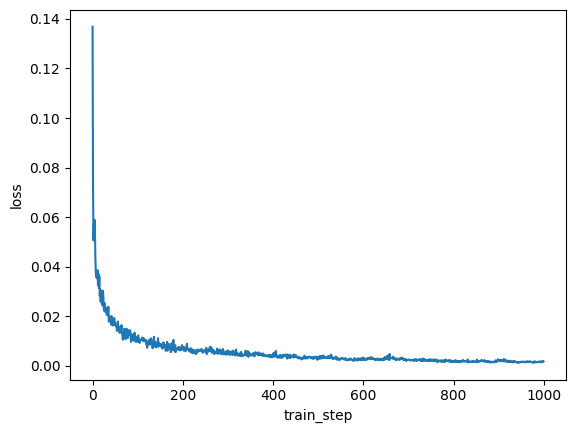

In [182]:
sns.lineplot(data=pd.DataFrame(train_loss), x="train_step", y="loss")

Looks like *some* learning is happening.

Now that our agent has supposedly learned how to behave in this environment, let's turn our camera on and film the agent.

In [183]:
video_rollout = run_policy(env, deterministic_ant, render=True)
save_vid(video_rollout.image_obs, 'assets/deterministic-ant.mp4')
Video('assets/deterministic-ant.mp4')

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x39307076/'vp09'


Looks good enough.

## Stochastic ant

Our student thus far has been using a *deterministic* policy. A common alternative is to use a *stochastic* policy. Instead of deterministically mapping an observation to an action, we map an observation to a *probability distribution over actions*. In practice we implement this stochasticity by having our neural net predict the parameters of some probability distribution over the action space. Since we are in continuous action space, a good choice for the probability distribution is the Gaussian distribution, whose mean and standard deviation are then the parameters our neural net will set.

In [184]:
class StochasticModel(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.mean_net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, act_dim)
        )
        # init the logstd to be 0 for each dim
        # same as init the std to be 1 for each dim
        self.logstd = nn.Parameter(torch.zeros(act_dim, dtype=torch.float32)) 
    
    def forward(self, obs):
        mean = self.mean_net(obs)
        std = self.logstd.exp() # numerical considerations
        return torch.distributions.normal.Normal(mean, std).rsample()

The method `.rsample()` is called on the probability distribution object (or a "random variable"--specifically in this case a "normal" or Gaussian random variable) to fetch an action. It samples while doing the so-called "reparameterization trick" (which is why the method is called "R"-sample). As the PyTorch documentation [explains](https://pytorch.org/docs/stable/distributions.html#pathwise-derivative), this "trick" consists in substituting a parameterized random variable with a parameterized deterministic function of a parameter-free random variable. This allows one to calculate the gradient through the random variable in our computational graph.

In [185]:
stochastic_ant = StochasticModel(obs_dim, act_dim)
optimizer = optim.Adam(stochastic_ant.parameters(), learning_rate)
_ = train(stochastic_ant, replay_buffer, loss_func, optimizer)

In [186]:
video_rollout = run_policy(env, stochastic_ant, render=True)
save_vid(video_rollout.image_obs, 'assets/stochastic-ant-tricky-start.mp4')
Video('assets/stochastic-ant-tricky-start.mp4')

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x39307076/'vp09'


Whoops, in this specific run of the stochastic ant, it happened to trip over. Is this to say that a stochastic policy is worse than a deterministic policy? To do a proper comparison, we need to look across many different rollouts and see if there is any significant difference in the rewards achieved by the deterministic ant on the one hand, and the stochastic hand on the other hand.

Let's write some functions to help us do that.

In [187]:
def evaluate_policy(env, policy, num_evaluation_steps=1000):
    '''
    Run the policy for `num_evaluation_steps` steps to collect 
    performance metrics.
    We may need to run the policy multiple times (run multiple episode) 
    to collect `num_evaluation_steps` as an episode might either terminate
    or get truncated earlier than that.
    '''
    policy.eval()
    rollouts = []
    i = 0
    while i < num_evaluation_steps:
        rollout = run_policy(env, policy, render=False)
        rollouts.append(rollout)
        i += len(rollout)
    return rollouts

def get_metrics(rollouts):
    returns = [rollout.total_reward for rollout in rollouts]
    ep_lens = [len(rollout) for rollout in rollouts]
    return {
        'avg_rollout_return': float(np.mean(returns)),
        'std_rollout_return': float(np.std(returns)),
        'avg_rollout_ep_len': float(np.mean(ep_lens))
    }

In [188]:
eval_rollouts_deterministic_ant = evaluate_policy(env, deterministic_ant, num_evaluation_steps=10000)
eval_rollouts_stochastic_ant = evaluate_policy(env, stochastic_ant, num_evaluation_steps=10000)
print('Deterministic ant:')
pprint(get_metrics(eval_rollouts_deterministic_ant))
print()
print('Stochastic ant:')
pprint(get_metrics(eval_rollouts_stochastic_ant))

Deterministic ant:
{
    "avg_rollout_return": 4710.3974609375,
    "std_rollout_return": 75.72673797607422,
    "avg_rollout_ep_len": 1000.0
}

Stochastic ant:
{
    "avg_rollout_return": 1176.189697265625,
    "std_rollout_return": 337.6606140136719,
    "avg_rollout_ep_len": 1000.0
}


It seems like the deterministic ant is doing better: higher average return and lower variance. Which is better--deterministic or stochastic--mostly depends on the nature of the environment. For example, if the environment is inherently stochastic, a stochastic might end up more appropriate. And as [this StackOverflow answer](https://ai.stackexchange.com/a/11652) suggests, "under some reasonable assumptions--like that the environment is fully-observed and is stationary--an optimal deterministic policy always exists... The same cannot be said for stochastic polices." In our case, the environment is *not* inherently stochastic--it's regulated by Newtonian physics--and it is fully observed, since our "observation" is a 111-dimensional vector fully specifying the state of the environment. It therefore makes sense that the deterministic ant does better than the stochastic ant.

## Limitations of behavioral cloning

There is, however, one problem with the behavioral cloning approach. Our ant--whether stochastic or deterministic--has only learned by watching videos of an expert and then getting evaluated directly. There was no *learning by doing*; no "trial and error".

Neural nets can generalize to some extent, but how would it fare if we started the environment in a very different state? To simulate that, we change a configuration in the "making" of the environment: specifically, we increase the noise on the positional values of the ant when the environment is initialized. We set `reset_noise_scale` to 2 (the default is 0.1).

In [191]:
env = gym.make(env_name, use_contact_forces=True, render_mode='rgb_array', terminate_when_unhealthy=False, reset_noise_scale=2)

Now let's put the same deterministic ant in this slightly different environment and see how it behaves.

In [194]:
video_rollout = run_policy(env, deterministic_ant, render=True)
save_vid(video_rollout.image_obs, 'assets/deterministic-ant-tricky-start.mp4')
Video('assets/deterministic-ant-tricky-start.mp4')

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x39307076/'vp09'


The deterministic ant is doing much worse! Let's again compare the deterministic and stochastic ants over multiple rollouts.

In [195]:
eval_rollouts_deterministic_ant = evaluate_policy(env, deterministic_ant, num_evaluation_steps=10000)
eval_rollouts_stochastic_ant = evaluate_policy(env, stochastic_ant, num_evaluation_steps=10000)
print('Deterministic ant:')
pprint(get_metrics(eval_rollouts_deterministic_ant))
print()
print('Stochastic ant:')
pprint(get_metrics(eval_rollouts_stochastic_ant))

Deterministic ant:
{
    "avg_rollout_return": 1031.725830078125,
    "std_rollout_return": 1859.4903564453125,
    "avg_rollout_ep_len": 1000.0
}

Stochastic ant:
{
    "avg_rollout_return": 418.171142578125,
    "std_rollout_return": 322.150634765625,
    "avg_rollout_ep_len": 1000.0
}


Both are doing much worse, but still the deterministic ant maintains an edge over the stochastic ant.

Let's see how we can add some *learning by doing*.

# Learning by doing

As we hinted, our learning ant suffers from a lack of exploration, as all its learning comes from watching a couple of videos of an expert ant. As we saw, if we put it in unfamiliar settings, the ant gets confused. What we want ideally is for our learning ant to explore the environment, try different things, and then eventually debrief with an expert. Together with the expert, it would go over the footage of its performance, and the expert would critique it, explaining what the learning ant could've done better at different points. Rather than just watching videos, the learning ant now gets to explore the space and use an active coach that tells it how to improve.

This approach is known as "DAgger", which stands for "data aggregation" (see the paper [here](https://www.cs.cmu.edu/~sross1/publications/Ross-AIStats11-NoRegret.pdf)). The basic idea is that, after bootstrapping our ant with the behavioral cloning approach, we then let it explore the environment for some time while we film it. Then we sit the student ant down with the expert and they watch the footage together. The expert ant then tells its student how it would have behaved in every situation the student found itself while exploring the environment on its own. The student learns from these debriefing sessions. Repeat. That's it!

To be able to do that, though, we need something more than just a couple of videos of the expert at work. We actually need to bring the expert in *in person*. In practice, that means we need its neural network, or in other words its policy.

Let's first bring in the expert ant. First we define it (it's very similar to our student ant). Then we load its pretrained weights.

In [196]:
class ExpertModel(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.obs_norm_mean = nn.Parameter(torch.zeros((1,obs_dim)))
        self.obs_norm_std = nn.Parameter(torch.zeros((1,obs_dim)))
        self.hidden_layers = nn.ModuleList([
            nn.Linear(obs_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
        ])
        self.non_lin = nn.Tanh()
        self.output_layer = nn.Linear(hidden_dim, act_dim)
    
    def forward(self, obs):
        normed_obs = (obs - self.obs_norm_mean) / (self.obs_norm_std + 1e-6)
        h = normed_obs
        for layer in self.hidden_layers:
            h = layer(h)
            h = self.non_lin(h)
        return self.output_layer(h)

Let's not forget to recreate our environment with the default initialization.

In [197]:
env = gym.make(env_name, use_contact_forces=True, render_mode='rgb_array', terminate_when_unhealthy=False)

In [198]:
def run_training_loop(num_iterations, env, student_policy, expert_policy, 
        replay_buffer, expert_data, loss_func, optimizer, num_evaluation_steps=10000):
    expert_policy.eval()
    replay_buffer.add_rollouts(expert_data) # seed the replay buffer with the expert videos
    metrics = []
    rollouts = []
    for i in range(num_iterations):
        # Train the student ant by sampling from the replay buffer.
        # At first, the replay buffer only contains expert data.
        # As we go, we will fill the replay buffer with student
        # rollouts "debriefed" with the expert ant
        train_loss = train(student_policy, replay_buffer, loss_func, optimizer)
        
        # explore
        student_rollouts = evaluate_policy(env, student_policy, 
            num_evaluation_steps=num_evaluation_steps)
        rollouts.append(student_rollouts)
        eval_metrics = get_metrics(student_rollouts)
        eval_metrics['train_loss'] = train_loss[-1]['loss']
        eval_metrics['iteration'] = i
        pprint(eval_metrics)
        metrics.append(eval_metrics)

        # "debrief", aka ask the expert ant what it would have done
        debriefed_rollouts = []
        for student_rollout in student_rollouts:
            # copying so `student_rollouts` still reflects the actions 
            # taken by the student, not the actions corrected by the expert
            debriefed_rollout = deepcopy(student_rollout)
            obs_batch = debriefed_rollout.observation
            with torch.no_grad():
                obs_batch = torch.from_numpy(obs_batch).float()
                act_batch = expert_policy(obs_batch)
                act_batch = act_batch.numpy()
            debriefed_rollout.action = act_batch
            debriefed_rollouts.append(debriefed_rollout)

        # add "corrected" student rollouts to the buffer
        replay_buffer.add_rollouts(debriefed_rollouts)
    return metrics, rollouts

In [215]:
replay_buffer = ReplayBuffer()
expert_ant = ExpertModel(obs_dim, act_dim)
expert_ant.load_state_dict(torch.load('./expert_policies/Ant.pt'))
student_ant = DeterministicModel(obs_dim, act_dim)
optimizer = optim.Adam(student_ant.parameters(), learning_rate)
num_iterations = 10
metrics, rollouts = run_training_loop(num_iterations, env, student_ant, expert_ant, 
    replay_buffer, expert_rollouts, loss_func, optimizer)

{
    "avg_rollout_return": 4482.587890625,
    "std_rollout_return": 92.59928894042969,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.0018948790384456515,
    "iteration": 0
}
{
    "avg_rollout_return": 4734.88525390625,
    "std_rollout_return": 122.81387329101562,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.0014976081438362598,
    "iteration": 1
}
{
    "avg_rollout_return": 4684.1875,
    "std_rollout_return": 101.32575988769531,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.0011810767464339733,
    "iteration": 2
}
{
    "avg_rollout_return": 4528.37451171875,
    "std_rollout_return": 676.86474609375,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.0011858310317620635,
    "iteration": 3
}
{
    "avg_rollout_return": 4782.2001953125,
    "std_rollout_return": 101.07830047607422,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.0008683454361744225,
    "iteration": 4
}
{
    "avg_rollout_return": 4817.53466796875,
    "std_rollout_return": 72

Let's compare the performance of the student as it learns to that of the expert. For that, let's simulate the same number of rollouts for the expert.

In [216]:
student_rewards = pd.DataFrame([
    {'return': r.total_reward, 'training_iteration': i} 
    for i,eval_rollouts in enumerate(rollouts) 
    for r in eval_rollouts
])

expert_eval_rollouts = [
    evaluate_policy(env, expert_ant, num_evaluation_steps=10000)
    for _ in range(num_iterations)
]

expert_rewards = pd.DataFrame([
    {'return': r.total_reward, 'training_iteration': i} 
    for i,eval_rollouts in enumerate(expert_eval_rollouts) 
    for r in eval_rollouts
])

<AxesSubplot:xlabel='training_iteration', ylabel='return'>

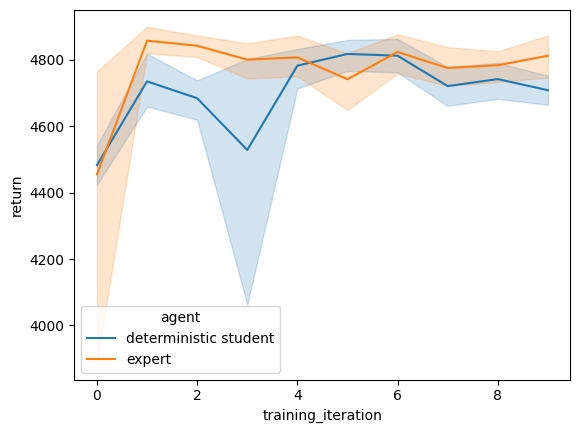

In [217]:
student_rewards['agent'] = 'deterministic student'
expert_rewards['agent'] = 'expert'
df = pd.concat([student_rewards, expert_rewards])
sns.lineplot(data=df, x="training_iteration", y="return", hue='agent')

The student learns so fast we can't really tell its progress on this chart. It's also kind of indistinguishable from the expert. Let's plot the slow student instead.

{
    "avg_rollout_return": 2472.870361328125,
    "std_rollout_return": 625.6759643554688,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.037754155695438385,
    "iteration": 0
}
{
    "avg_rollout_return": 4365.9638671875,
    "std_rollout_return": 101.13018798828125,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.015416349284350872,
    "iteration": 1
}
{
    "avg_rollout_return": 4452.6064453125,
    "std_rollout_return": 404.5533447265625,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.00768670067191124,
    "iteration": 2
}
{
    "avg_rollout_return": 4612.7431640625,
    "std_rollout_return": 171.84092712402344,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.005211961921304464,
    "iteration": 3
}
{
    "avg_rollout_return": 4662.505859375,
    "std_rollout_return": 113.56459045410156,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.003559350036084652,
    "iteration": 4
}
{
    "avg_rollout_return": 4788.0048828125,
    "std_rollout_return": 1

<AxesSubplot:xlabel='training_iteration', ylabel='return'>

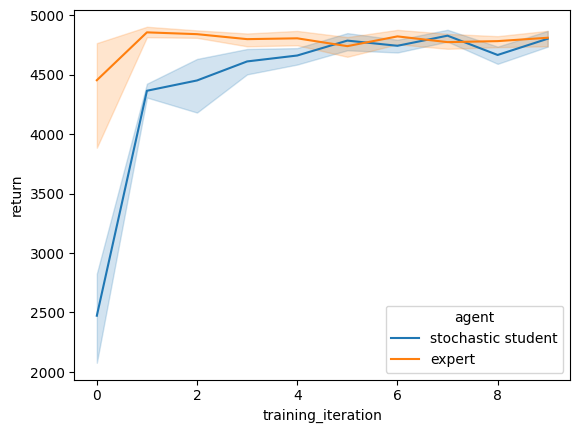

In [218]:
replay_buffer = ReplayBuffer()
student_ant = StochasticModel(obs_dim, act_dim)
optimizer = optim.Adam(student_ant.parameters(), learning_rate)
metrics, rollouts = run_training_loop(num_iterations, env, student_ant, expert_ant, 
    replay_buffer, expert_rollouts, loss_func, optimizer)
student_rewards = pd.DataFrame([
    {'return': r.total_reward, 'training_iteration': i} 
    for i,eval_rollouts in enumerate(rollouts) 
    for r in eval_rollouts
])
student_rewards['agent'] = 'stochastic student'
expert_rewards['agent'] = 'expert'
df = pd.concat([student_rewards, expert_rewards])
sns.lineplot(data=df, x="training_iteration", y="return", hue='agent')

Eventually the stochastic ant reaches expert level--it just takes a bit longer than for a deterministic ant. 

Not let's see if learning by doing improves outcome in the slightly changed environment we explored earlier.

In [219]:
env = gym.make(env_name, use_contact_forces=True, render_mode='rgb_array', terminate_when_unhealthy=False, reset_noise_scale=2)

{
    "avg_rollout_return": 228.73095703125,
    "std_rollout_return": 1536.2230224609375,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.0016535961767658591,
    "iteration": 0
}
{
    "avg_rollout_return": 275.85113525390625,
    "std_rollout_return": 274.6333923339844,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.0044042449444532394,
    "iteration": 1
}
{
    "avg_rollout_return": 1291.0517578125,
    "std_rollout_return": 1703.4432373046875,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.005161683540791273,
    "iteration": 2
}
{
    "avg_rollout_return": 751.6449584960938,
    "std_rollout_return": 764.10693359375,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.0052405293099582195,
    "iteration": 3
}
{
    "avg_rollout_return": 705.6612548828125,
    "std_rollout_return": 1096.0367431640625,
    "avg_rollout_ep_len": 1000.0,
    "train_loss": 0.00481629092246294,
    "iteration": 4
}
{
    "avg_rollout_return": 1098.263916015625,
    "std_rollout_r

<AxesSubplot:xlabel='training_iteration', ylabel='return'>

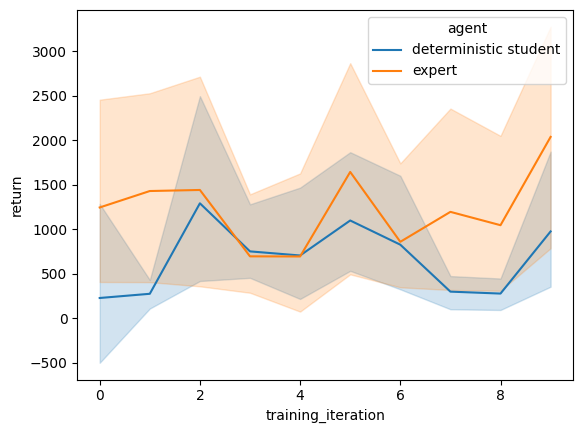

In [221]:
replay_buffer = ReplayBuffer()
student_ant = DeterministicModel(obs_dim, act_dim)
optimizer = optim.Adam(student_ant.parameters(), learning_rate)
metrics, rollouts = run_training_loop(num_iterations, env, student_ant, expert_ant, 
    replay_buffer, expert_rollouts, loss_func, optimizer)
student_rewards = pd.DataFrame([
    {'return': r.total_reward, 'training_iteration': i} 
    for i,eval_rollouts in enumerate(rollouts) 
    for r in eval_rollouts
])
expert_eval_rollouts = [
    evaluate_policy(env, expert_ant, num_evaluation_steps=10000)
    for _ in range(num_iterations)
]
expert_rewards = pd.DataFrame([
    {'return': r.total_reward, 'training_iteration': i} 
    for i,eval_rollouts in enumerate(expert_eval_rollouts) 
    for r in eval_rollouts
])
student_rewards['agent'] = 'deterministic student'
expert_rewards['agent'] = 'expert'
df = pd.concat([student_rewards, expert_rewards])
sns.lineplot(data=df, x="training_iteration", y="return", hue='agent')

It turns out that our expert is in fact a "narrow" expert. It too was only trained with initial states in a limited range. Therefore, it can't really help our student in this changed environment. That said, in theory, learning by doing here would supplant strict behavioral cloning.